In [64]:
from datasets import list_datasets
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import torch
from transformers import AutoModel
import numpy as np
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
from huggingface_hub import notebook_login
from transformers import Trainer, TrainingArguments

# Text Classification
Usaremos DistilBERT para realizar sentiment analysis. DistilBERT logra un rendimiento similar a BERT teniendo un tamaño mucho menor.

Podemos usar checkpoints para cargar un conjunto de pesos determinados asignados a un modelo en concreto.

## Datasets 
Cargamos datasets usando Hugging face Datasets

In [2]:
all_datasets = list_datasets()
print(f'There are {len(all_datasets)} datasets currently available on the Hub')
print(f'The first 10 are: {all_datasets[:10]}')

There are 24567 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


We can load a specific dataset using the `load_dataset()` function:

In [3]:
emotions = load_dataset("emotion")

No config specified, defaulting to: emotion/split
Found cached dataset emotion (C:/Users/jcav/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

We can print some information about this `emotions` object

In [4]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

We can use the usual dictionary syntax to access an individual split:

In [5]:
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [6]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [7]:
train_ds.column_names

['text', 'label']

Podemos consultar las posibles labels utilizando `.features`. Lo que revela, en este caso, que las posibles categorías son: 'sadness', 'joy', 'love', 'anger', 'fear', 'surprise' 

In [8]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


Para cargar un dataset que no se encuentre en el Hub, podemos utilizar `load_dataset("csv", data_files="my_file.csv")`

Para cargar datos a partir de una URL:

In [9]:
# dataset_url = "https://dropbox.com/s/1pzkadrvffbqw6o/train.txt"
# !wget{dataset_url}
# emotions_local = load_dataset("csv", data_files="train.txt", sep=";", names=["text", "label"])

In [10]:
# dataset_url = "https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt?dl=1"
# emotions_remote = load_dataset("csv", data_files=dataset_url, sep=";", names=["text", "label"])

En ocasiones es recomendable convertir los datasets de hugging face a pandas para poder acceder a todas las funciones de esta librería. Para ello, podemos utilizar el método `set_format()`, que cambia el formato de salida del dataset.

In [11]:
emotions.set_format(type='pandas')
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


Las labels se han convertido en integers, por lo que utilizamos el método `int2str()` para volver a convertirlas en strings.

In [12]:
def label_int2str(row):
    return emotions['train'].features['label'].int2str(row)

In [13]:
df['label_name'] = df['label'].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


Análisis de la distribución de las clases.

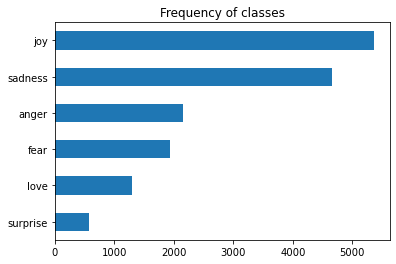

In [14]:
df['label_name'].value_counts(ascending=True).plot.barh()
plt.title('Frequency of classes')
plt.show()

The dataset is heavily imbalanced; the joy and sadness classes appear frequently, whereas love and suprise are about 5-10 times rarer.

Análisis de la longitud de los tweets. La máxima longitud de la entrada en DistilBERT es 512 tokens.

Text(0.5, 0.98, '')

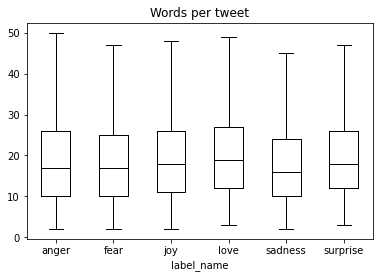

In [15]:
df['Words per tweet'] = df['text'].str.split().apply(len)
df.boxplot('Words per tweet', by="label_name", grid=False, showfliers=False, color='black')
plt.suptitle('')

## Tokenization

**Debemos usar siempre el mismo Tokenizador que el modelo.**

La mayoría de los modelos no pueden recibir texto plano como entrada, deben recibir el texto tokenizado y convertido (encoded) como vectores numéricos. Recuerda que pipeline y modelo no son lo mismo, la pipeline incluye el proceso de tokenización. Podemos tokenizar por caracteres, por palabras o por "subpalabras". La tokenización por caracteres apenas se usa en la práctica. Subword tokenization nos permite realizar un proceso de tokenización sin tener que usar un vocabulario de grandes dimensiones.

In [16]:
text = "Tokenizing is a core task of NLP."

### Subword tokenization
Subword tokenization combina los mejores aspectos de la tokenización por caracteres y palabras. 
- Divide palabras poco comunes en unidades más pequeñas para permitir al modelo lidiar con palabras complejas y errores de escritura.
- Mantiene palabras comunes como entidades únicas para mantener la longitud de nuestros inputs dentro de un tamaño razonable.

La principal característica de subword tokenization es que aprende del corpus de pretraining utilizando una mezcla de reglas estadísticas y algoritmos.

Hugging face Transformers ofrece una clase `AutoTokenizer` que permite cargar rápidamente el tokenizer asociado con el modelo preentrenado, utilizando el método `from_pretrained()` y el ID del modelo.

In [17]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [18]:
# Método alternativo
# from transformers import DistilBertTokenizer
# distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

Aplicamos el tokenizador. Las palabras han sido mapeadas a integers únicos.

In [19]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Convertimos los ids en tokens.

In [20]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [21]:
encoded_text2 = tokenizer("Armies is the plural of army. Children is the plural of child. Phones is the plural of phone. Smartphones is the plural of smartphone")
print(encoded_text2)

{'input_ids': [101, 8749, 2003, 1996, 13994, 1997, 2390, 1012, 2336, 2003, 1996, 13994, 1997, 2775, 1012, 11640, 2003, 1996, 13994, 1997, 3042, 1012, 26381, 2015, 2003, 1996, 13994, 1997, 26381, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [22]:
tokens2 = tokenizer.convert_ids_to_tokens(encoded_text2.input_ids)
print(tokens2)

['[CLS]', 'armies', 'is', 'the', 'plural', 'of', 'army', '.', 'children', 'is', 'the', 'plural', 'of', 'child', '.', 'phones', 'is', 'the', 'plural', 'of', 'phone', '.', 'smartphone', '##s', 'is', 'the', 'plural', 'of', 'smartphone', '[SEP]']


`[CLS]` y `[SEP]` indican el inicio y el final de una secuencia.

Podemos volver a convertirlo en un string.

In [23]:
tokenizer.convert_tokens_to_string(tokens)

'[CLS] tokenizing is a core task of nlp. [SEP]'

Podemos comprobar distintas propiedades, como el tamaño del vocabulario y el **tamaño máximo del contexto.**

In [24]:
# Tamaño del vocabulario
tokenizer.vocab_size

30522

In [25]:
# Maximum context size
tokenizer.model_max_length

512

In [26]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

### Tokenizar el dataset completo
Tokenizaremos el dataset completo utilizando la función `map()`. Primero, definimos una función de tokenización:

In [27]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

- `padding=True`: Añade ceros al final hasta alcanzar el tamaño máximo del batch.
- `truncation=True`: Trunca los ejemplos al máximo tamaño del contexto.

In [28]:
# Hacemos que el dataset deje de ser un DataFrame de pandas
emotions.reset_format()

In [29]:
print(tokenize(emotions['train'][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


**Podemos observar que al padding se le asigna un attention score de 0.**

Una vez definida una función de procesado, podemos aplicarla a todos los splits en el corpus en una sola línea de código.

In [30]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Loading cached processed dataset at C:\Users\jcav\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-6c2fbaf1500f5012.arrow
Loading cached processed dataset at C:\Users\jcav\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-698b44fb169807a2.arrow
Loading cached processed dataset at C:\Users\jcav\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-a90e6091b63c7fde.arrow


In [31]:
print(emotions_encoded['train'].column_names)

['text', 'label', 'input_ids', 'attention_mask']


## Training a text Classifier
Para entrenar un text classifier, tenemos dos opciones:
- **Feature extraction:** Utilizamos los hidden states como features y las usamos para entrenar un clasificador con ellas, sin modificar el modelo preentrenado. Simplemente añadimos la cabeza de clasificación y la entrenamos.
- **Fine-tuning:** Entrenamos el modelo completo (end-to-end), lo que también actualiza los parámetros del modelo preentrenado.

### Transformers como feature extractors
Dejamos el modelo tal y como está y añadimos una cabeza, que es la parte que se entrena. La cabeza no tiene que ser necesariamente una red neuronal, podría ser un random forest. Utilizaremos el método `from_pretrained()` de la clase `AutoModel`.

In [32]:
model_ckpt = "distilbert-base-uncased"
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


La clase `AutoModel` convierte los encodings de los tokens en embeddings, que son utilizados como entradas para la capa de encoder, resultando en hidden states.

In [33]:
# El siguiente código devuelve los últimos hidden states de un string
text = "This is a test"
inputs = tokenizer(text, return_tensors='pt')   # Convertimos (encode) el string y lo convertimos en un tensor de Pytorch
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


El tamaño del tensor resultante tiene la forma [batch_size, n_tokens]

Colocamos los encodings en el mismo dispositivo que el modelo y pasamos los parámetros al input de la siguiente forma:

In [34]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]), hidden_states=None, attentions=None)


`torch.no_grad()` deshabilita el cálculo automático del gradiente, lo que reduce el uso de memoria de los cálculos.

In [35]:
# size = [n_batches, n_tokens, hidden_dim], a 768-dimensional vector is returned for each of the 6 input tokens
print(outputs[0].shape)
print(outputs.last_hidden_state.size())

torch.Size([1, 6, 768])
torch.Size([1, 6, 768])


En tareas de clasificación es común usar el hidden state asociado con el token [CLS]. 

Este token encapsula el significado de toda la secuencia de input. Esto se consigue entrenando el modelo para predecir si una input sequence pertenece a una clase en concreto, usando el token [CLS] como entrada de la capa de clasificación. Sin embargo, en algunos casos otros tokens en la secuencia de input pueden ser más relevantes para la tarea a realizar. 

In [36]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

Creamos una función que extraiga los hidden states de todo el dataset creando una columna `hidden_state` que almacene estos vectores.

In [37]:
def extract_hidden_states(batch):
    # Place model inputs on GPU
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
        # Return vector for [CLS] token
        return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

Como nuestro modelo recibe tensores como entrada, el siguiente paso consiste en convertir `input_ids` y `attention_mask` en tensores de pytorch.

In [38]:
emotions_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

In [39]:
# Ahora podemos extraer los hidden states de todos los splits
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [40]:
emotions_encoded['train']

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 16000
})

In [41]:
emotions_encoded['train']['input_ids']

tensor([[  101,  1045,  2134,  ...,     0,     0,     0],
        [  101,  1045,  2064,  ...,     0,     0,     0],
        [  101, 10047,  9775,  ...,     0,     0,     0],
        ...,
        [  101,  1045,  2514,  ...,     0,     0,     0],
        [  101,  1045,  2514,  ...,     0,     0,     0],
        [  101,  1045,  2113,  ...,     0,     0,     0]])

In [42]:
emotions_hidden['train'].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [43]:
emotions_hidden['train']['hidden_state']

tensor([[-0.1168,  0.0986, -0.1296,  ...,  0.0587,  0.3543,  0.4042],
        [-0.0324, -0.0323, -0.1957,  ..., -0.1747,  0.3546,  0.3028],
        [ 0.0397,  0.2022,  0.1423,  ..., -0.1141,  0.3394,  0.3958],
        ...,
        [-0.0034, -0.0959,  0.0584,  ..., -0.0427,  0.2496,  0.3076],
        [ 0.0666,  0.1733,  0.1290,  ...,  0.0612,  0.2904,  0.4684],
        [ 0.0167,  0.1013, -0.0073,  ..., -0.0649,  0.3454,  0.2199]])

Una vez tenemos los hidden states, el siguiente paso es utilizarlos para entrenar un clasificador. Para ello, debemos crear una feature matrix.

In [44]:
X_train = np.array(emotions_hidden['train']['hidden_state'])
X_valid = np.array(emotions_hidden['validation']['hidden_state'])

y_train = np.array(emotions_hidden['train']['label'])
y_valid = np.array(emotions_hidden['validation']['label'])

In [45]:
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

**Visualizando el conjunto de entrenamiento:** Usamos el algoritmo UMAP para proyectar los vectores en 2D. UMAP funciona mejor en el intervalo [0,1], así que primero aplicaremos `MinMaxScaler` y después usaremos la librería `umap-learn` para ver los hidden states.

In [46]:
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric='cosine').fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.464338,7.375511,0
1,-2.917268,7.068353,0
2,5.077981,3.740644,3
3,-2.767284,4.355202,2
4,-3.432452,5.069812,3


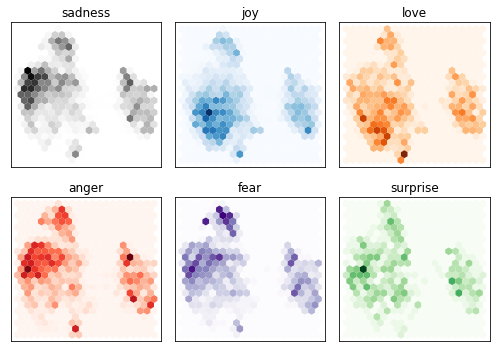

In [47]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions['train'].features['label'].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub['X'], df_emb_sub['Y'], cmap=cmap, gridsize=20, linewidth=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

**Usando un clasificador simple:** Vamos a usar los hidden states para entrenar una regresión logística.

In [49]:
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

Utilizamos `DummyClassifier` como baseline.

In [52]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

Confusion matrix:

In [55]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

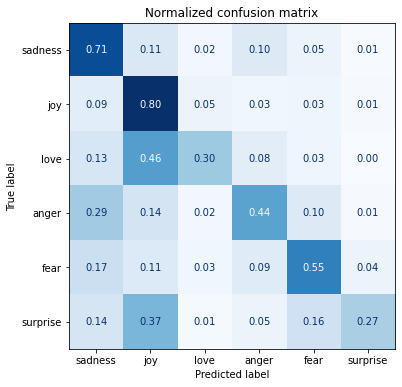

In [56]:
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

### Fine-tuning de Transformers
En lugar de utilizar los hidden states como features ya definidas, todos los parámetros del modelo son entrenables.

Entrenar los hidden states evita que trabajemos con datos que no sean adecuados para la tarea de clasificación. Utilizaremos La API `Trainer` de Hugging Face Transformers para simplificar el proceso de entrenamiento.

#### 1. Cargar un modelo ya entrenado
Debemos usar `AutoModelForSequenceClassification` en lugar de `AutoModel`. La diferencia está en que este modelo tiene una cabeza de clasificación, que puede ser fácilmente entrenada con el modelo base. 

Solo tenemos que indicar el número de labels que el modelo tiene que predecir, lo que determina el número de salidas de la cabeza de clasificación.

In [59]:
num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

#### 2. Definir métricas de rendimiento

In [61]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy" : acc, "f1": f1}

In [63]:
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (manager-core).
Your token has been saved to C:\Users\jcav\.cache\huggingface\token
Login successful


In [65]:
batch_size = 64
logging_steps = len(emotions_encoded['train']) # batch size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                 num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error"
                                 )

In [66]:
trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer
                 )
trainer.train()

Cloning https://huggingface.co/Carsick/distilbert-base-uncased-finetuned-emotion into local empty directory.
C:\Users\jcav\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.312114,0.910000,0.907628
2,No log,0.215143,0.925500,0.925624


TrainOutput(global_step=500, training_loss=0.5371781005859375, metrics={'train_runtime': 2927.3647, 'train_samples_per_second': 10.931, 'train_steps_per_second': 0.171, 'total_flos': 720342861696000.0, 'train_loss': 0.5371781005859375, 'epoch': 2.0})

In [67]:
# Predecimos en el conjunto de validación
preds_output = trainer.predict(emotions_encoded['validation'])

In [68]:
preds_output.metrics

{'test_loss': 0.2151426076889038,
 'test_accuracy': 0.9255,
 'test_f1': 0.9256237719536403,
 'test_runtime': 50.0688,
 'test_samples_per_second': 39.945,
 'test_steps_per_second': 0.639}

In [69]:
y_preds = np.argmax(preds_output.predictions, axis=1)

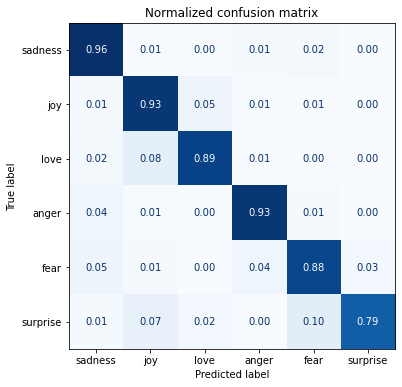

In [70]:
plot_confusion_matrix(y_preds, y_valid, labels)

#### 3. Error analysis
Available on the book.

#### 4. Push and convert into pipeline
Available on the book.